# Analyzing Food Balance and Nutrition Habits
### Author: Liad Dekel

## Introduction:
As a person undergoing a diet change and a nutrition process over the last year the world wide nutrition question curioused me a lot. It's clear that the world is changing a lot in the way it treats food,
but when the change truly started ? What is changing any why ? I'll try to answer some of these questions. 

My purpose in this project is showing **global patterns** in `nutrion` and `food consumption` areas over that last 65 years.

After showing some general intresting statistics, i will focus on the new `vegan` fashion we see in the last century and will compare it with `meat` industry and `meat` consumption in different aspects.

I'll finish by trying to correllate changes in the economic fields with changes in nutrition habits.

In [26]:
# create datasets dir
!mkdir -p ./datasets/fao-food-balance

DATA_NEW_URL = "fenixservices.fao.org/faostat/static/bulkdownloads/FoodBalanceSheets_E_All_Data_(Normalized).zip"
DATA_HISTORY_URL = "fenixservices.fao.org/faostat/static/bulkdownloads/FoodBalanceSheetsHistoric_E_All_Data_(Normalized).zip"

# download the data
!wget "$DATA_NEW_URL" -P ./datasets/fao-food-balance
!wget "$DATA_HISTORY_URL" -P ./datasets/fao-food-balance

# unzip data
!unzip ./datasets/fao-food-balance/'FoodBalanceSheetsHistoric_E_All_Data_(Normalized).zip' -d ./datasets/fao-food-balance
!unzip ./datasets/fao-food-balance/'FoodBalanceSheets_E_All_Data_(Normalized).zip' -d ./datasets/fao-food-balance

# why putting parenthesses in your file name ? :(
!mv ./datasets/fao-food-balance/'FoodBalanceSheets_E_All_Data_(Normalized).csv' ./datasets/fao-food-balance/FoodBalanceSheets_E_All_Data.csv
!mv ./datasets/fao-food-balance/'FoodBalanceSheetsHistoric_E_All_Data_(Normalized).csv' ./datasets/fao-food-balance/FoodBalanceSheetsHistoric_E_All_Data.csv

In [55]:
import pandas as pd

DATA_NEW_PATH = "./datasets/fao-food-balance/FoodBalanceSheets_E_All_Data.csv"
DATA_HISTORY_PATH = "./datasets/fao-food-balance/FoodBalanceSheetsHistoric_E_All_Data.csv"

df_food_balance_new = pd.read_csv(DATA_NEW_PATH, encoding="ISO-8859-1")
df_food_balance_historic = pd.read_csv(DATA_HISTORY_PATH, encoding="ISO-8859-1")

In [56]:
import numpy as np
import turicreate as tc

# we'll start by merging both new and old versions in order to infer insights over long period of time.
df_food_balance = df_food_balance_historic.append(df_food_balance_new, ignore_index=True)

# convert to SFrame, the data contains 12,000,000 lines!
df_food_balance.replace({np.nan: None,"Ethiopia PDR": "Ethiopia"}, inplace=True)
sf_food_balance = tc.SFrame(df_food_balance)

# remove redundant columns
sf_food_balance = sf_food_balance.remove_columns(
    ['Area Code', 'Item Code', 'Year Code','Element Code','Flag']) 

In [57]:
sf_food_balance

Columns:
	Area	str
	Item	str
	Element	str
	Year	int
	Unit	str
	Value	float

Rows: 12706759

Data:
+-------------+------------+-------------------------------+------+--------------+
|     Area    |    Item    |            Element            | Year |     Unit     |
+-------------+------------+-------------------------------+------+--------------+
| Afghanistan | Population | Total Population - Both sexes | 1961 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1962 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1963 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1964 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1965 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1966 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1967 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1968 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1969 | 1000 persons |
| Afghanistan | Population | Total Population - Both sexes | 1970 | 1000 persons |
+-------------+------------+-------------------------------+------+--------------+
+---------+
|  Value  |
+---------+
|  8954.0 |
|  9142.0 |
|  9340.0 |
|  9547.0 |
|  9765.0 |
|  9990.0 |
| 10222.0 |
| 10466.0 |
| 10729.0 |
| 11016.0 |
+---------+
[12706759 rows x 6 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [58]:
# utils functions
def get_elements(sf, elements=None, substring=None):
    """Return rows with given list of elements in the supplied SFrame.
    
    input
    -----
        :elements (list[str]): strings of elements requested in the given SFrame.
        :sf (SFrame): sframe to filter.
    """
    if substring:
        return sf.filter_by(filter(lambda x : substring in x.lower(), sf['Element']), 'Element')
    elif elements:
        return sf.filter_by(elements, 'Element')
        
def get_items(sf, items=None, substring=None):
    """Return rows with given list of items in the supplied SFrame.
    
    input
    -----
        :items (list[str]): strings of items requested in the given SFrame.
        :sf (SFrame): sframe to filter.
    """
    if substring:
        return sf.filter_by(filter(lambda x : substring in x.lower(), sf['Item']), 'Item')
    elif items:
        return sf.filter_by(items, 'Item')
    
def get_areas(sf, areas):
    """Return rows with given list of items in the supplied SFrame.
    
    input
    -----
        :items (list[str]): strings of items requested in the given SFrame.
        :sf (SFrame): sframe to filter.
    """
    return sf.filter_by(areas, 'Area')

## General Staticstics

In [59]:
import plotly.express as px
from turicreate import aggregate as agg


items = [
    'Meat', 'Fish, Seafood','Animal fats', 'Wheat and products', 
    'Sugar & Sweeteners', 'Fruits - Excluding Wine', 'Vegetables', 'Cereals - Excluding Beer', 
    'Rice (Milled Equivalent)', 'Alcoholic Beverages'
]

sf_food_types = get_items(sf_food_balance, items=items)
sf_food_types = get_elements(sf_food_types, elements=["Food supply (kcal/capita/day)"])
sf_food_types = sf_food_types.groupby(['Item', 'Year'],operations={'Avg Value': agg.AVG('Value')})
sf_food_types = sf_food_types.sort('Year')

# convert to dataframe in order to ease plotting
df_food_types = sf_food_types.to_dataframe()
fig = px.bar(df_food_types, x='Avg Value', y='Item', 
             animation_frame='Year', color='Item',
             title="Average World Food Types Consumption (kcal/capita/day)")
fig.show()

In [6]:
import plotly.express as px

# meat consumption per capita
sf_meat = get_items(sf_food_balance, items=['Meat'])
sf_meat_per_capita = get_elements(sf_meat, elements=["Food supply (kcal/capita/day)"])

px.choropleth(sf_meat_per_capita,
              locations='Area',
              locationmode='country names',
              color='Value',
              color_continuous_scale="Viridis",
              projection='natural earth',
              animation_frame='Year',
              title="Meat Supply Per Capita For a Day")


## The Vegan Fashion

It feels like common knowledge that the world is going towards `green` lifes, which is based on more `vegan` nutrition.
This not only in order to reduce the suffer of animals but also due to `health` reasons. We will try to demonstrate these habits. It's already seems like something bigger then a temporary `fashion`.


Text(0.5, 1.0, 'Meat Supply Per Capita a Day (kcal)')

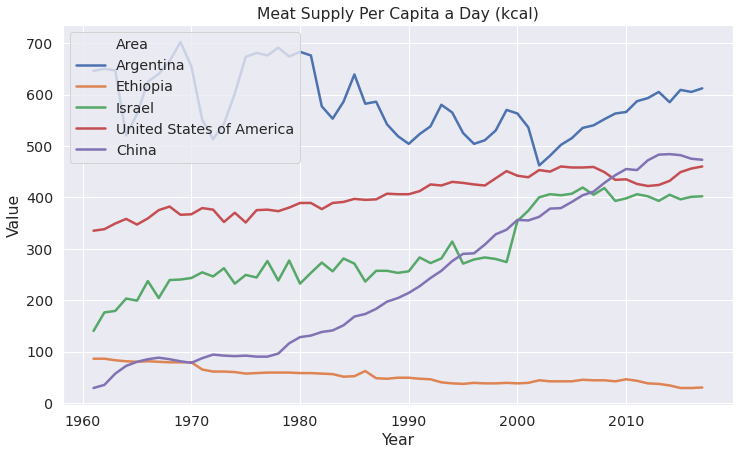

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# let's look specifically on number of intresting countries:
areas = ['Argentina', 'United States of America', 'China', 'Ethiopia', 'Israel']
sf_meat_per_capita = get_areas(sf_meat_per_capita, areas)

plt.figure(figsize=(12, 7))
sns.set(font_scale=1.3, style="darkgrid", rc={"lines.linewidth": 2.5})

# convert to dataframe to ease plotting
df_meat_per_capita = sf_meat_per_capita.to_dataframe()
sns.lineplot(x='Year', y='Value', hue='Area', data=df_meat_per_capita).set_title("Meat Supply Per Capita a Day (kcal)")

**In the graph above we can see number of interesting insights:**
1. For more then 60 years `Argentina` is leading in the meat supply per capita a day. The amount is not stable but yet the highest.
2. Around the 60's `China` barely consumed `meat`. We can see the drastic incresae until now and these days they are even passing `USA`!! Can we relate this to the development of the chinese `economy` ? 
3. Even though the american known for their "fat" and "full with meat" culture, their average consumed amount is increasing very slow comparing to other different countries.
4. `Ethiopia` was the only country with constant decrease in the consumption per capita. `Economy` again ?
5. Something is changing around 2010 ... let's try to zoom on this one.

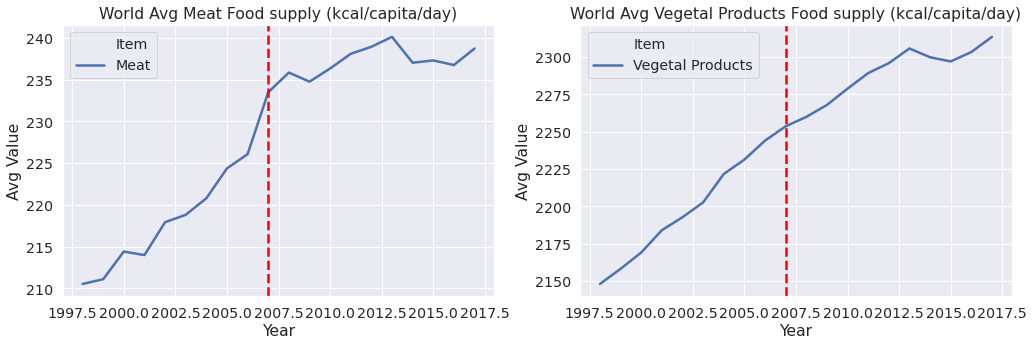

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from turicreate import aggregate as agg



# let's look specifically on number of intresting countries:
sf_foods_per_capita = get_elements(sf_food_balance, elements=["Food supply (kcal/capita/day)"])
# we would like look on the second millenia
sf_foods_per_capita = sf_foods_per_capita[sf_foods_per_capita['Year'] >= 1998]
# average value of all countries
sf_foods_per_capita = sf_foods_per_capita.groupby(['Year', 'Item'],operations={'Avg Value': agg.AVG('Value')})

sf_meat = get_items(sf_foods_per_capita, items=['Meat'])
sf_vegie = get_items(sf_foods_per_capita, items=['Vegetal Products'])


# convert to dataframe to ease plotting
df_meat = sf_meat.to_dataframe()
df_vegie = sf_vegie.to_dataframe()

# plot as two subplots
sns.set(font_scale=1.3, style="darkgrid", rc={"lines.linewidth": 2.5})
fig, ax = plt.subplots(1,2, figsize=(17, 5))
sns.lineplot(x='Year', y='Avg Value', hue='Item', data=df_meat, ax=ax[0]).set_title("World Avg Meat Food supply (kcal/capita/day)")
sns.lineplot(x='Year', y='Avg Value', hue='Item', data=df_vegie, ax=ax[1]).set_title("World Avg Vegetal Products Food supply (kcal/capita/day)")

# mark 2007 in figures
ax[0].axvline(2007, color="red", linestyle="--")
ax[1].axvline(2007, color="red", linestyle="--")

we can see that around **2007** something is changing in the world's meat consumption. In the two figures above, we see that line is not rising up ruther almost stay in it's place comparing to the years before. On the other hand the vegeteal supply is keep rising in the same pace.

The left figure is giving us a very big news: **the world is decreasing drastically it's meat consumtion!!**

**This change seems very drastic. What could have made this ?**

One major thing that happend on this time area is the `financial crisis of 2007–2008`, intresting if this drastic change is related! more details on the crisis can be found [here](https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008).

## Similar Nutrion Habits
Let's try to find countries with similar nutrion habits using `clustering`.
In order to reduce pre processing we will use this time the 'not normalized' version of the data. With this version we will have rows wich contains the value for all tested years together.

In [1]:
# create datasets dir
!mkdir -p ./datasets/similar-habits/

DATA_NEW_NOT_NORMALIZED = "http://fenixservices.fao.org/faostat/static/bulkdownloads/FoodBalanceSheets_E_All_Data.zip"

# download the data
!wget "$DATA_NEW_NOT_NORMALIZED" -P ./datasets/similar-habits/
# unzip the data
!unzip ./datasets/similar-habits/FoodBalanceSheets_E_All_Data.zip -d ./datasets/similar-habits

--2020-07-22 16:03:21--  http://fenixservices.fao.org/faostat/static/bulkdownloads/FoodBalanceSheets_E_All_Data.zip
Resolving fenixservices.fao.org (fenixservices.fao.org)... 193.43.36.139
Connecting to fenixservices.fao.org (fenixservices.fao.org)|193.43.36.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6648550 (6.3M) [application/x-zip-compressed]
Saving to: ‘./datasets/similar-habits/FoodBalanceSheets_E_All_Data.zip’

FoodBalanceSheets_E 100%[===================>]   6.34M   613KB/s    in 8.6s    

2020-07-22 16:03:30 (755 KB/s) - ‘./datasets/similar-habits/FoodBalanceSheets_E_All_Data.zip’ saved [6648550/6648550]

--2020-07-22 16:03:30--  http://fenixservices.fao.org/faostat/static/bulkdownloads/FoodBalanceSheetsHistoric_E_All_Data.zip
Resolving fenixservices.fao.org (fenixservices.fao.org)... 193.43.36.139
Connecting to fenixservices.fao.org (fenixservices.fao.org)|193.43.36.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2

In [37]:
import pandas as pd

DATA_NEW_PATH_NN = "./datasets/similar-habits/FoodBalanceSheets_E_All_Data_NOFLAG.csv"

df_food_balance_new_not_normalized = pd.read_csv(DATA_NEW_PATH_NN, encoding="ISO-8859-1")
# let's take a look on the dataframe to see it's advantage when dealing with clusters
df_food_balance_new_not_normalized

Area Code                                     Area  Item Code  \
0               2                              Afghanistan       2501   
1               2                              Afghanistan       2501   
2               2                              Afghanistan       2901   
3               2                              Afghanistan       2901   
4               2                              Afghanistan       2901   
...           ...                                      ...        ...   
315472       5817  Net Food Importing Developing Countries       2899   
315473       5817  Net Food Importing Developing Countries       2899   
315474       5817  Net Food Importing Developing Countries       2899   
315475       5817  Net Food Importing Developing Countries       2899   
315476       5817  Net Food Importing Developing Countries       2899   

                 Item  Element Code                                 Element  \
0          Population           511           Total Population - Both sexes   
1          Population          5301                Domestic supply quantity   
2         Grand Total           664           Food supply (kcal/capita/day)   
3         Grand Total           674  Protein supply quantity (g/capita/day)   
4         Grand Total           684      Fat supply quantity (g/capita/day)   
...               ...           ...                                     ...   
315472  Miscellaneous          5142                                    Food   
315473  Miscellaneous           645     Food supply quantity (kg/capita/yr)   
315474  Miscellaneous           664           Food supply (kcal/capita/day)   
315475  Miscellaneous           674  Protein supply quantity (g/capita/day)   
315476  Miscellaneous           684      Fat supply quantity (g/capita/day)   

                   Unit     Y2014     Y2015     Y2016     Y2017  
0          1000 persons  33370.79  34413.60  35383.03  36296.11  
1           1000 tonnes      0.00      0.00      0.00      0.00  
2       kcal/capita/day   2019.00   1978.00   2001.00   2000.00  
3          g/capita/day     56.11     54.62     54.56     54.09  
4          g/capita/day     32.77     30.41     31.24     30.62  
...                 ...       ...       ...       ...       ...  
315472      1000 tonnes   1097.00   1126.00   1144.00   1370.00  
315473               kg      0.81      0.82      0.81      0.95  
315474  kcal/capita/day      1.00      1.00      1.00      1.00  
315475     g/capita/day      0.03      0.03      0.03      0.03  
315476     g/capita/day      0.01      0.01      0.01      0.01  

[315477 rows x 11 columns]

In [40]:
import numpy as np
import turicreate as tc

# convert to SFrame, over 12,000,000 lines!
df_food_balance_new_not_normalized.replace({np.nan: None,"Ethiopia PDR": "Ethiopia"}, inplace=True)
sf_food_balance_not_normalized = tc.SFrame(df_food_balance_new_not_normalized)

# remove redundant columns
sf_food_balance_not_normalized = sf_food_balance_not_normalized.remove_columns(
    ['Area Code', 'Item Code','Element Code']) 

sf_food_balance_nn = get_elements(sf_food_balance_not_normalized, elements=["Food supply (kcal/capita/day)"])
sf_food_balance_meat_nn = get_items(sf_food_balance_nn, items=['Meat'])
sf_food_balance_vegie_nn = get_items(sf_food_balance_nn, items=['Vegetal Products'])

In [12]:
!pip install networkx

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

from math import sqrt

# we will use basic metric to calculate number of clusters
k = int(sqrt(sf_food_balance_meat_nn.num_rows() / 2.0))
# get all years as features
features = [r for r in sf_food_balance_meat_nn.column_names() if r.startswith("Y")]
model = tc.kmeans.create(sf_food_balance_meat_nn, label='Area', features=features, num_clusters=k)

color_map = {
    0:"green",
    1:"red",
    2:"blue",
    3:"yellow",
    4:"brown",
    5:"pink",
    6:"purple",
    7:"grey",
    8:"black",
    9:"orange"
}
colors = []

def add_cluster_to_network(G, model, cluster_number):
    ci = model.cluster_id
    sf_cluster = ci[ci['cluster_id'] == cluster_number]
    
    G.add_node(f'centroid_{cluster_number}')
    colors.append(color_map[int(cluster_number) % len(color_map)])
    
    for area, distance in zip(sf_cluster['Area'], sf_cluster['distance']):
        G.add_node(area, color='r', size=10)
        colors.append(color_map[int(cluster_number) % len(color_map)])
        G.add_edge(area, f'centroid_{cluster_number}')
    return 


G = nx.Graph()
ci = model.cluster_id

for cluster in ci['cluster_id'].unique():
        add_cluster_to_network(G, model, cluster)

Batch size is larger than the input dataset. Switching to an exact Kmeans method.

Choosing initial cluster centers with Kmeans++.

+---------------+-----------+

| Center number | Row index |

+---------------+-----------+

| 0             | 27        |

| 1             | 194       |

| 2             | 147       |

| 3             | 2         |

| 4             | 94        |

| 5             | 181       |

| 9             | 167       |

+---------------+-----------+

Starting kmeans model training.

Assigning points to initial cluster centers.

+-----------+-------------------------------+

| Iteration | Number of changed assignments |

+-----------+-------------------------------+

| 1         | 14                            |

| 2         | 6                             |

| 3         | 2                             |

| 4         | 3                             |

| 5         | 1                             |

| 6         | 0                             |

+-----------+-------------------------------+

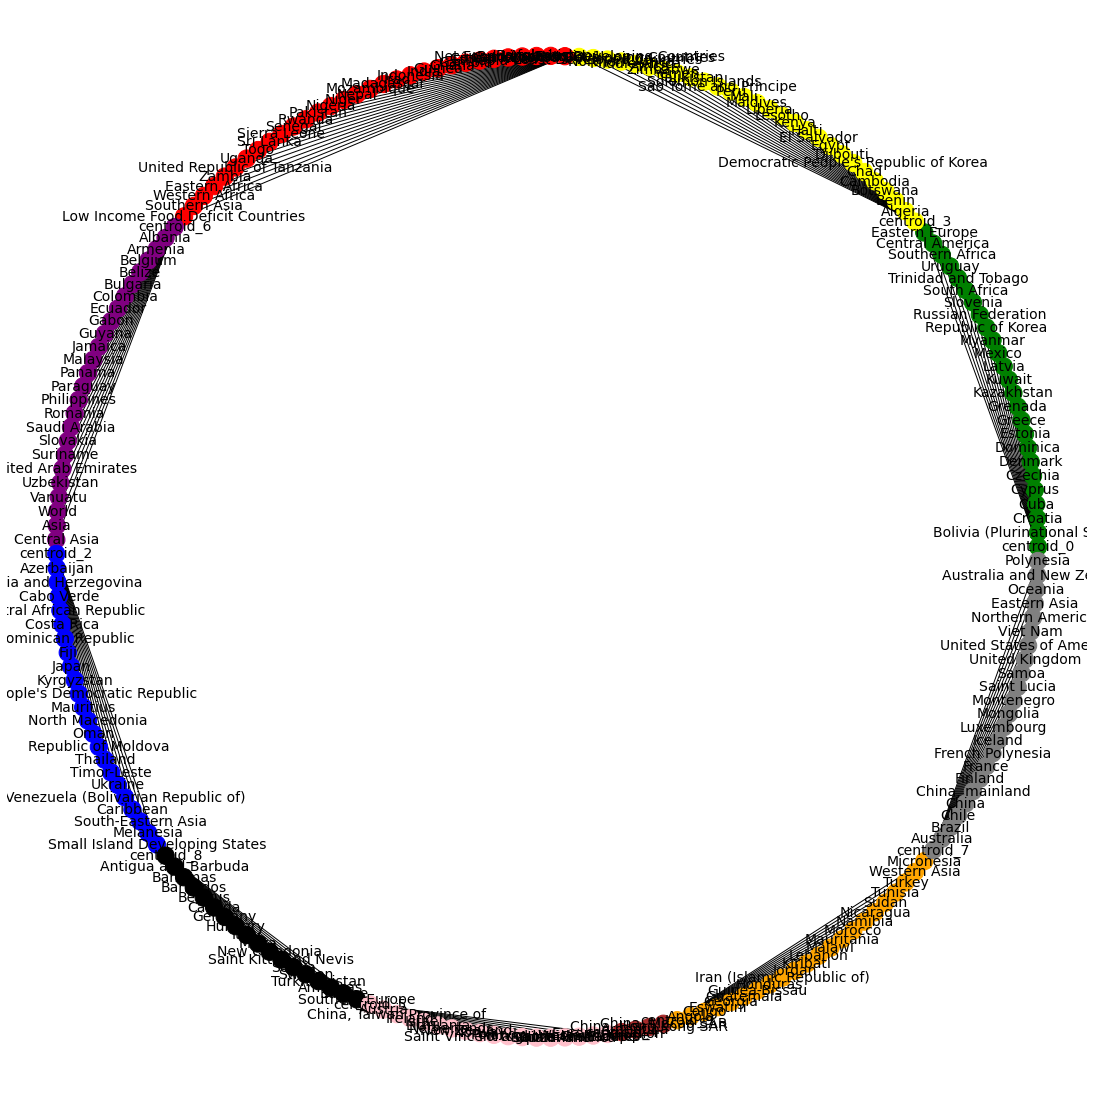

In [46]:
plt.figure(figsize=(15,15))
nx.draw_shell(G, with_labels=True, node_color=colors, font_size=14)

Using these clusters we can see countries with similar nutrion habits over time.
The network above is showing clusters of countries with similar `Meat` consumption habits in 2014-2017 years.
This infact a very intersting information which we can infer a lot from.

**We can see the following:**
1. Many islamic countries are in the same cluster - Turkey, Tunisia, Iran, Lebanon etc.
2. Israel is with Ireland, Netherland, lithuania.
3. USA is with Australia, France and China!

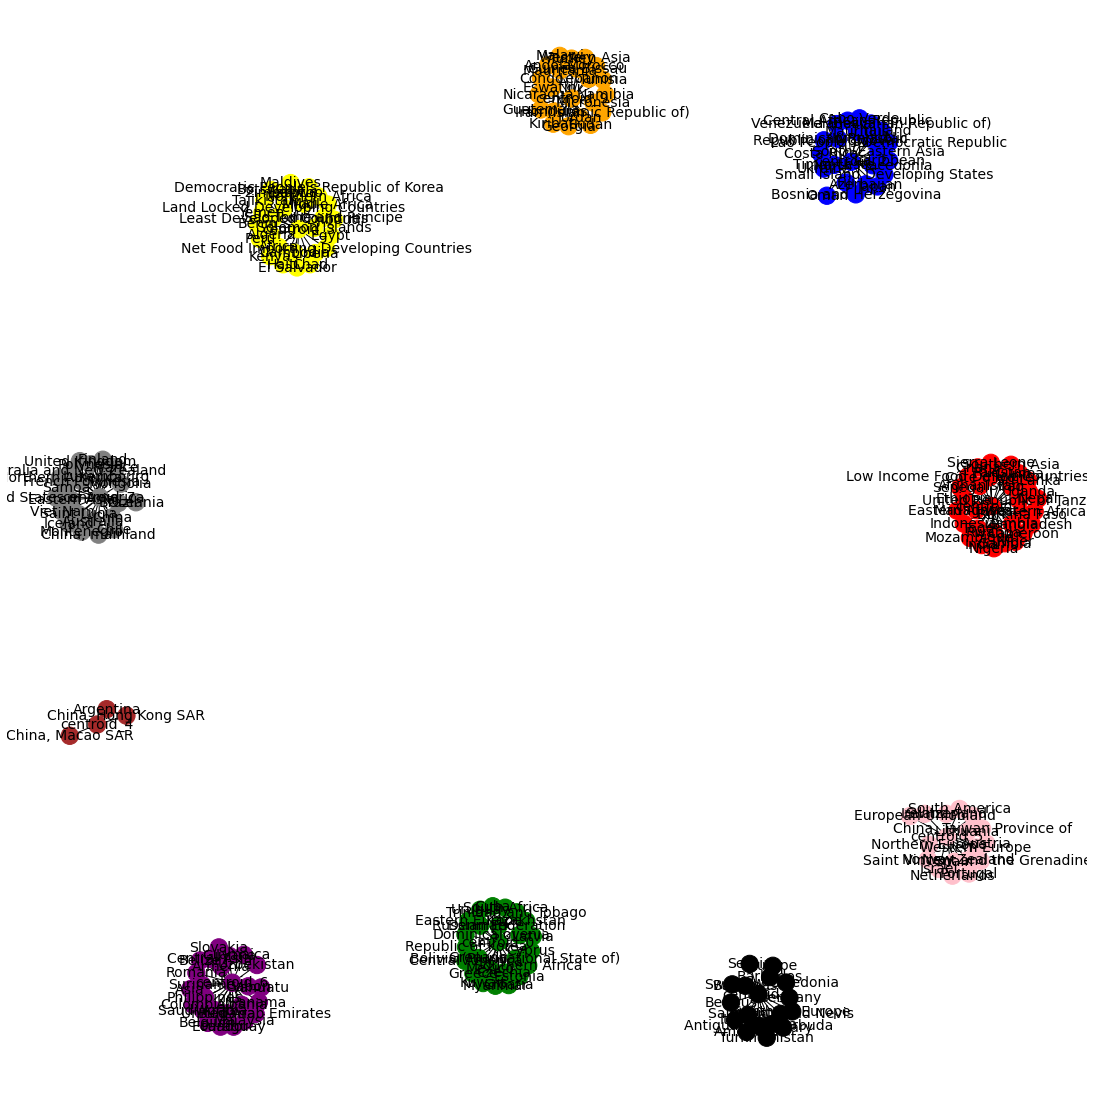

In [50]:
# we can also draw as spring in order to see the actual clusters but it's less readable
plt.figure(figsize=(15,15))
nx.draw_spring(G, with_labels=True, node_color=colors, font_size=14)

## Corellating Nutrion Habits
Intresting idea can be to find correlation between other fields to nutrion habits. Such field can 
be the `economic` field that was already marked by us as intresting field related to the nutrion field.

we would like to see the influence of the average salary on nutrition habits. For this we will use average `salary` data of the `oecd coutries`:

In [174]:
import pycountry

def iso3_convert(name):
    try:
        a = pycountry.countries.get(name=name).alpha_3
    except:
        a = ""
    return a
        
# Let's convert our origin dataset area names to ISO-3 using pycountry
sf_food_balance['Area'] = sf_food_balance['Area'].apply(iso3_convert)

### Average Salary

In [18]:
!mkdir ./datasets/average-salary
DATA_AVG_SALARY = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/AUS+AUT+BEL+CAN+CHE+CHL+CZE+DEU+DNK+ESP+EST+FIN+FRA+GBR+GRC+HUN+IRL+ISL+ISR+ITA+JPN+KOR+LTU+LUX+LVA+MEX+NLD+NOR+NZL+POL+PRT+SVK+SVN+SWE+TUR+USA.AVWAGE.TOT.USD.A/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1990&endPeriod=2017'

# download the average salary data
!wget "$DATA_AVG_SALARY" -O ./datasets/average-salary/oced-avg-salary.csv

mkdir: cannot create directory ‘./datasets/average-salary’: File exists
--2020-07-20 23:42:09--  https://stats.oecd.org/sdmx-json/data/DP_LIVE/AUS+AUT+BEL+CAN+CHE+CHL+CZE+DEU+DNK+ESP+EST+FIN+FRA+GBR+GRC+HUN+IRL+ISL+ISR+ITA+JPN+KOR+LTU+LUX+LVA+MEX+NLD+NOR+NZL+POL+PRT+SVK+SVN+SWE+TUR+USA.AVWAGE.TOT.USD.A/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1990&endPeriod=2017
Resolving stats.oecd.org (stats.oecd.org)... 78.41.130.147
Connecting to stats.oecd.org (stats.oecd.org)|78.41.130.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘./datasets/average-salary/oced-avg-salary.csv’

./datasets/average-     [  <=>               ]  51.08K   196KB/s    in 0.3s    

2020-07-20 23:42:10 (196 KB/s) - ‘./datasets/average-salary/oced-avg-salary.csv’ saved [52310]



In [176]:
import turicreate as tc

# organize the data
sf_average_salary = tc.SFrame.read_csv("./datasets/average-salary/oced-avg-salary.csv")
sf_average_salary = sf_average_salary.rename({"Value":"Salary", "TIME":"Year", "LOCATION":"Area"})

# join food consumption and average salary
sf_average_salary = sf_average_salary.join(sf_food_balance, how='inner', on=['Year', 'Area'])

Finished parsing file /home/liad/dev/bgu/analyzing-big-data/project/datasets/average-salary/oced-avg-salary.csv

Parsing completed. Parsed 100 lines in 0.005036 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,int,float,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/liad/dev/bgu/analyzing-big-data/project/datasets/average-salary/oced-avg-salary.csv

Parsing completed. Parsed 918 lines in 0.003476 secs.

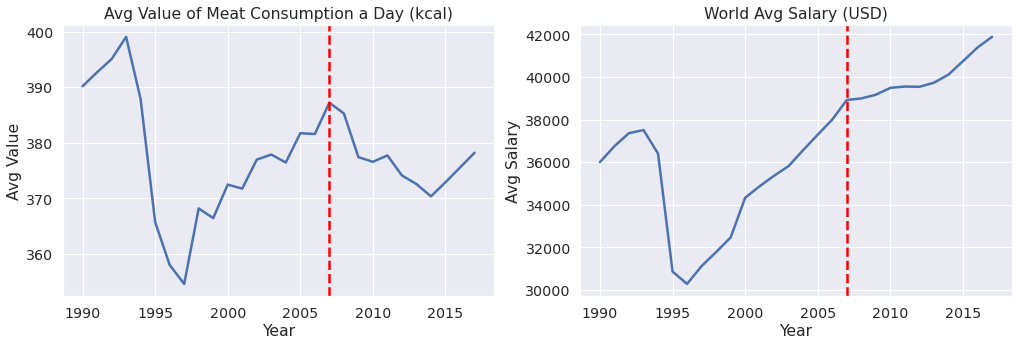

In [211]:
item = 'Meat'
sf_food_average_salary = get_items(sf_average_salary, items=[item])
sf_food_average_salary = get_elements(sf_food_average_salary, elements=['Food supply (kcal/capita/day)'])
sf_food_average_salary = sf_food_average_salary.groupby(['Item', 'Year'],operations={'Avg Value': agg.AVG('Value'),
                                                                                         'Avg Salary': agg.AVG('Salary')})

df_food_average_salary = sf_food_average_salary.sort('Year').to_dataframe()
df_food_average_salary_until_2008 = df_food_average_salary[df_food_average_salary['Year'] <= 2008]

fig, ax = plt.subplots(1,2, figsize=(17, 5))
sns.lineplot(x='Year', y='Avg Value',  data=df_food_average_salary, ax=ax[0]).set_title(f"Avg Value of {item} Consumption a Day (kcal)")
sns.lineplot(x='Year', y='Avg Salary', data=df_food_average_salary, ax=ax[1]).set_title(f"World Avg Salary (USD)")
# mark 2007 in figures
ax[0].axvline(2007, color="red", linestyle="--")
ax[1].axvline(2007, color="red", linestyle="--")

In [210]:
print("world correlation between meat consumption and average salary:",df_food_average_salary.corr(method='pearson')['Avg Salary']['Avg Value'])
print("\nworld correlation between meat consumption and average salary until 2008:",df_food_average_salary_until_2008.corr(method='pearson')['Avg Salary']['Avg Value'])

world correlation between meat consumption and average salary: 0.468711822162335

world correlation between meat consumption and average salary until 2008: 0.8558297147200051


As we already know something happend to the meat consumption in the world after around 2008. 
Hence the correlation is hurt when calculating until 2017. If we look only on the data until 2008, the correlation will be much **higher**.

We can inffer an intresting insights from these calculations:
1. **The more money you are earning to more meat you are eating (at least until 2008)**
2. Let's focues for one moment on the data after 2008. Even though the average salary is keep increasing the meat consumption is decreasing! **people are eating less meat even though they can afford it and more**. This seems like a real change indication!

### Unemployment Rate

In [79]:
!mkdir ./datasets/average-unemployment
DATA_AVG_UNEMPLOY = 'https://stats.oecd.org/sdmx-json/data/DP_LIVE/AUS+AUT+BEL+CAN+CHE+CHL+CZE+DEU+DNK+EA19+ESP+EST+FIN+FRA+GBR+GRC+HUN+IRL+ISL+ISR+ITA+JPN+KOR+LTU+LUX+LVA+MEX+NLD+NOR+NZL+OECD+POL+PRT+SVK+SVN+SWE+TUR+USA.HUR.TOT.PC_LF.A/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1961&endPeriod=2017'

# download the average unemployment data
!wget "$DATA_AVG_UNEMPLOY" -O ./datasets/average-unemployment/oced-avg-unemploy.csv

--2020-07-21 20:08:12--  https://stats.oecd.org/sdmx-json/data/DP_LIVE/AUS+AUT+BEL+CAN+CHE+CHL+CZE+DEU+DNK+EA19+ESP+EST+FIN+FRA+GBR+GRC+HUN+IRL+ISL+ISR+ITA+JPN+KOR+LTU+LUX+LVA+MEX+NLD+NOR+NZL+OECD+POL+PRT+SVK+SVN+SWE+TUR+USA.HUR.TOT.PC_LF.A/OECD?contentType=csv&detail=code&separator=comma&csv-lang=en&startPeriod=1961&endPeriod=2017
Resolving stats.oecd.org (stats.oecd.org)... 78.41.130.147
Connecting to stats.oecd.org (stats.oecd.org)|78.41.130.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘./datasets/average-unemployment/oced-avg-unemploy.csv’

./datasets/average-     [  <=>               ]  52.99K   187KB/s    in 0.3s    

2020-07-21 20:08:13 (187 KB/s) - ‘./datasets/average-unemployment/oced-avg-unemploy.csv’ saved [54257]



In [157]:
import turicreate as tc

sf_average_unemploy = tc.SFrame.read_csv("./datasets/average-unemployment/oced-avg-unemploy.csv")
sf_average_unemploy = sf_average_unemploy.rename({"Value":"Unemploy", "TIME":"Year", "LOCATION":"Area"})

# join on Area and Year
sf_average_unemploy = sf_average_unemploy.join(sf_food_balance, how='inner', on=['Year', 'Area'])

Finished parsing file /home/liad/dev/bgu/analyzing-big-data/project/datasets/average-unemployment/oced-avg-unemploy.csv

Parsing completed. Parsed 100 lines in 0.00472 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,str,str,int,float,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/liad/dev/bgu/analyzing-big-data/project/datasets/average-unemployment/oced-avg-unemploy.csv

Parsing completed. Parsed 1154 lines in 0.003731 secs.

Text(0.5, 1.0, 'World Avg Human Unemploy Rate (%)')

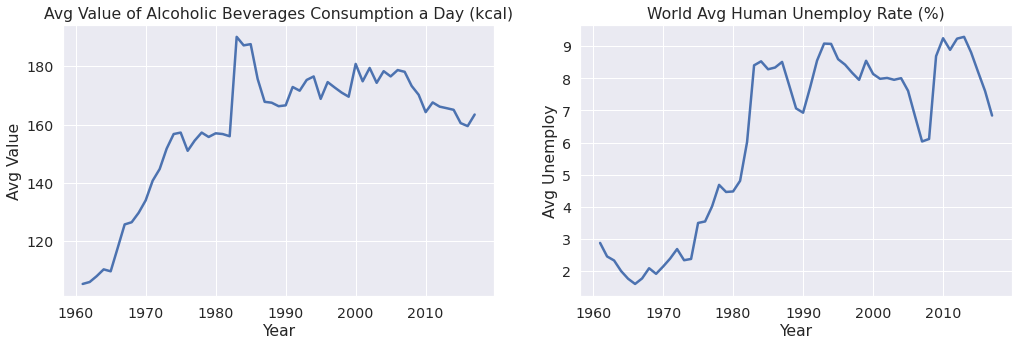

In [217]:
item = 'Alcoholic Beverages'
sf_average_meat_unemploy = get_items(sf_average_unemploy, items=[item])
sf_average_meat_unemploy = get_elements(sf_average_meat_unemploy, elements=['Food supply (kcal/capita/day)'])
sf_average_meat_unemploy = sf_average_meat_unemploy.groupby(['Item', 'Year'],operations={'Avg Value': agg.AVG('Value'),
                                                                                         'Avg Unemploy': agg.AVG('Unemploy')})

df_average_meat_unemploy = sf_average_meat_unemploy.sort('Year').to_dataframe()

fig, ax = plt.subplots(1,2, figsize=(17, 5))
sns.lineplot(x='Year', y='Avg Value',  data=df_average_meat_unemploy, ax=ax[0]).set_title(f"Avg Value of {item} Consumption a Day (kcal)")
sns.lineplot(x='Year', y='Avg Unemploy', data=df_average_meat_unemploy, ax=ax[1]).set_title(f"World Avg Human Unemploy Rate (%)")

In [215]:
print("world correlation between alcohol consumption and hur rate:",df_average_meat_unemploy.corr(method='pearson')['Avg Unemploy']['Avg Value'])

world correlation between alcohol consumption and hur rate: 0.8377828434831518


If you asked yourself what unemployed people usually do, the answer is right infront of you.
We can see a very **high** correlation between consumption of `alcohol` and the `HUR` - Human Unemployment Rate.